# Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import IPython.display as display
import tensorflow_datasets as tfds

## Network Construction

### Hyperparameter

In [2]:
EPOCHS = 45
BATCH_SIZE = 128
LR_RATE = 0.001
MOMENTUM = 0.7
L2_LAMBDA = 0.01

 ### Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data.
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

### Loss Function

#### L2 Regularisation

In [4]:
class RegularisedLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs**2) * L2_LAMBDA)
        return inputs  # Pass-through layer.

#### Cross Entropy

In [5]:
class CrossEntropy(keras.losses.Loss):
    def __init__(self, name="loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
      # y_true_one_hot = tf.one_hot(y_true, depth=10)

      # Replace prediction values to avoid log(0) error.
      y_pred = tf.clip_by_value(y_pred, 1e-15, 1.)
      # Cross entropy.
      entropy = tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), 1))
      return entropy

### Learning Rate Decay Schedule

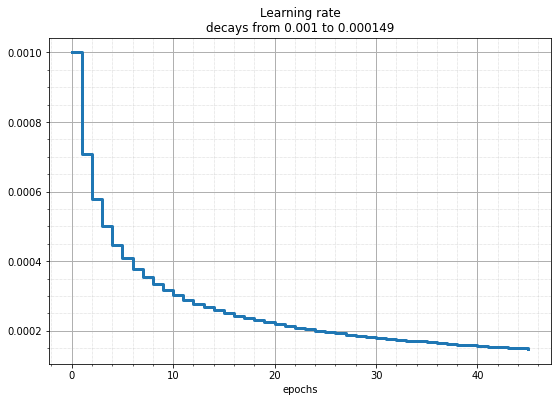

In [6]:
# Learning rate decay function.
def lr_decay(epoch):
  return LR_RATE / math.sqrt(1+epoch)

# Utility callback that reflects the learning rate decay.
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')

# Display the learning rate decay.
plot_learning_rate(lr_decay, EPOCHS)

### Visualisation functions

In [7]:
def accuracy_result(model):
  # Result for accuracy.
  plt.plot(model.history['accuracy'])
  plt.plot(model.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [8]:
def loss_result(model):
  # Result for loss.
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

### Network Architecture

In [9]:
class LogitNetwork(tf.keras.Model):

  def __init__(self):
    super(LogitNetwork, self).__init__()

    # Initialising the network layer.
    self.initialiser = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

  def initialise(self):
    # Network design.
    model = tf.keras.Sequential() # Initial network.
    model.add(RegularisedLayer())
    model.add(tf.keras.layers.Dense(10, 
                                activation='softmax', 
                                kernel_initializer=self.initialiser,
                                #kernel_regularizer=tf.keras.regularizers.L2(0.01)
                                )) # Output layer.
    return model
    

  def __call__(self, optimiser):
    model = self.initialise()
    model.compile(optimizer=optimiser, 
                  loss=CrossEntropy(),
                  metrics=["accuracy"]
                  )
    
    return model

## Network initialisation

In [10]:
model = LogitNetwork()

## Testing different optimisers

In [11]:
# Dictionary of 4 different optimisers.
optimiser_list = {
    "SGD": tf.optimizers.SGD(learning_rate=LR_RATE, momentum=MOMENTUM, name="SGD"),
    "Nesterov": tf.keras.optimizers.SGD(learning_rate=LR_RATE, momentum=MOMENTUM, nesterov=True, name='Nesterov'),
    "AdaGrad": tf.keras.optimizers.Adagrad(learning_rate=LR_RATE, name='AdaGrad'),
    "ADAM": tf.keras.optimizers.Adam(learning_rate=LR_RATE, name='ADAM')
}

In [12]:
# Looping through 4 different optimisers.
def loop_model(optimiser_list, x_train, y_train, BATCH_SIZE, EPOCHS):

  # Initialise output dictionary.
  model_config = {}
  model_history = {}

  # Implement optimiser and fitting the network.
  for key, item in optimiser_list.items():
    print("\n")
    print(f"#### {key} Training ####")
    model_config[key] = model(item)
    model_history[key] = model_config[key].fit(x_train,
                                               y_train,
                                               batch_size=BATCH_SIZE,
                                               epochs=EPOCHS,
                                               validation_data=(x_test, y_test),
                                               verbose=0,
                                               callbacks=[lr_decay_callback])
  return model_config, model_history

model_config, model_history = loop_model(optimiser_list, x_train, y_train, BATCH_SIZE, EPOCHS)



#### SGD Training ####

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0007071067811865475.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005773502691896258.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0004472135954999579.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004082482904638631.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0003779644730092272.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.00035355339059327376.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0003333333333333333.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.00031622776601683794.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.00030151134457776364.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0002

### SGD

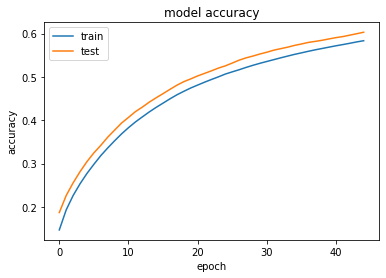

In [13]:
accuracy_result(model_history["SGD"])

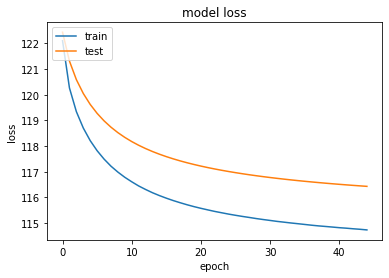

In [14]:
loss_result(model_history["SGD"])

In [15]:
# Model evaluation.
print("Evaluate on test data")
results = model_config["SGD"].evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 0s 2ms/step - loss: 116.4296 - accuracy: 0.6030
test loss, test acc: [116.42963409423828, 0.6029999852180481]


### Nesterov Momentum SGD

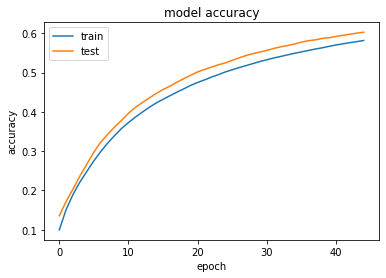

In [16]:
accuracy_result(model_history["Nesterov"])

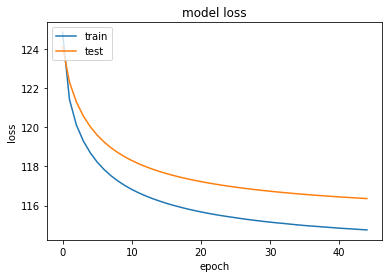

In [17]:
loss_result(model_history["Nesterov"])

In [18]:
# Model evaluation.
print("Evaluate on test data")
results = model_config["Nesterov"].evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 0s 2ms/step - loss: 116.3552 - accuracy: 0.6025
test loss, test acc: [116.35517120361328, 0.6025000214576721]


### AdaGrad

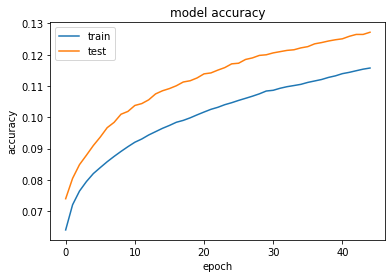

In [19]:
accuracy_result(model_history["AdaGrad"])

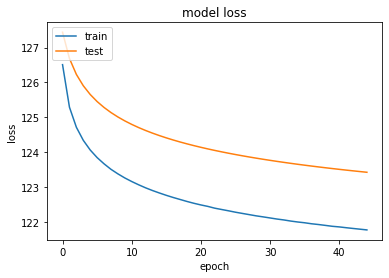

In [20]:
loss_result(model_history["AdaGrad"])

In [21]:
# Model evaluation.
print("Evaluate on test data")
results = model_config["AdaGrad"].evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 0s 2ms/step - loss: 123.4209 - accuracy: 0.1272
test loss, test acc: [123.42085266113281, 0.12720000743865967]


### Adam

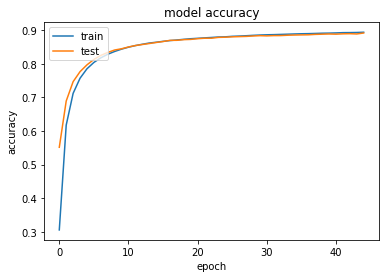

In [22]:
accuracy_result(model_history["ADAM"])

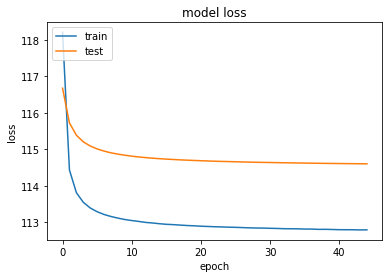

In [23]:
loss_result(model_history["ADAM"])

In [24]:
# Model evaluation.
print("Evaluate on test data")
results = model_config["ADAM"].evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 0s 2ms/step - loss: 114.6041 - accuracy: 0.8918
test loss, test acc: [114.60408782958984, 0.8917999863624573]
